In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data

In [2]:
# Read data from csv
df = pd.read_csv("data/rental_prices_singapore_preprocessed.csv")

In [3]:
# Show dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1680 entries, 0 to 1679
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price               1680 non-null   int64  
 1   size                1680 non-null   int64  
 2   bedrooms            1680 non-null   object 
 3   bathrooms           1680 non-null   int64  
 4   latitude            1680 non-null   float64
 5   longitude           1680 non-null   float64
 6   meters_to_cbd       1680 non-null   int64  
 7   meters_to_school    1680 non-null   int64  
 8   restaurants_rating  1680 non-null   float64
 9   property_type       1680 non-null   object 
 10  furnishing          1680 non-null   object 
 11  year                1680 non-null   int64  
 12  meters_to_mrt       1680 non-null   int64  
 13  high_floor          1680 non-null   bool   
 14  new                 1680 non-null   bool   
 15  renovated           1680 non-null   bool   
 16  view  

In [4]:
# Show top five rows
df.head()

,price,size,bedrooms,bathrooms,latitude,longitude,meters_to_cbd,meters_to_school,restaurants_rating,property_type,furnishing,year,meters_to_mrt,high_floor,new,renovated,view,penthouse
0,3000,400,1,1,1.312952,103.887868,6744,422,4.126316,Apartment,Fully Furnished,2013,450,False,False,False,False,False
1,2000,1130,Room,1,1.328820,103.912904,14317,3422,3.800000,Apartment,Fully Furnished,2013,810,False,False,False,False,False
2,7400,3800,5,4,1.389444,103.857002,15497,568,4.710000,Apartment,Fully Furnished,2013,450,False,False,False,False,False
3,1000,120,Room,1,1.429261,103.828917,22825,1090,3.605263,Apartment,Fully Furnished,2013,700,False,False,False,False,False
4,4300,689,1,1,1.297356,103.836707,3070,1262,4.120000,Apartment,Fully Furnished,2013,420,False,False,False,False,False


# Handle rare categories

In [5]:
# Bedrooms
# Combine 7, 8, 9 and 10 bedrooms into one category
df["bedrooms"]= df["bedrooms"].replace({"8": "7", "9": "7", "10": "7"})

# Rename this category to "7+"
df["bedrooms"]= df["bedrooms"].replace({"7": "7+"})

# Train-validation-test split

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
# Split the data into X features and y target
X = df.drop("price", axis=1)
y = df["price"]

In [8]:
# Split the data into training and temporary sets (70% train, 30% temporary)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the temporary data into validation and test sets (50% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Note: This accomplishes a 70% training, 15% validation and 15% test set size.

# Feature scaling

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
# Initialize a StandardScaler object
scaler = StandardScaler()

In [11]:
# Store the numerical columns
numerical_columns = ["size", "bathrooms", "latitude", "longitude", "meters_to_mrt", "meters_to_cbd", 
                     "meters_to_school", "restaurants_rating", "year"]

In [12]:
# Perform z-score normalization on numerical columns
X_train_scaled = scaler.fit_transform(X_train[numerical_columns])
X_val_scaled = scaler.transform(X_val[numerical_columns])
X_test_scaled = scaler.transform(X_test[numerical_columns])

In [13]:
# Convert numpy arrays to pandas dataframes and assign the original column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=numerical_columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=numerical_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=numerical_columns)

In [14]:
# Assign the index of the new dataframes to match the originial dataframes' index
X_train_scaled.index = X_train.index
X_val_scaled.index = X_val.index
X_test_scaled.index = X_test.index

# Feature encoding

In [15]:
from sklearn.preprocessing import OneHotEncoder

In [16]:
# Store categorical columns
categorical_columns = ["bedrooms", "property_type", "furnishing"]

In [17]:
# Initialize a OneHotEncoder object
encoder = OneHotEncoder(drop=None, sparse=False)

In [18]:
# Perform one-hot encoding on categorical columns
X_train_encoded = encoder.fit_transform(X_train[categorical_columns])
X_val_encoded = encoder.transform(X_val[categorical_columns])
X_test_encoded = encoder.transform(X_test[categorical_columns])

In [20]:
# Get names of the one-hot encoded features
encoded_feature_names = encoder.get_feature_names_out(input_features=categorical_columns)

# Define a mapping dictionary to change names
column_name_mapping = {
    "bedrooms_Room": "bedrooms_room",
    "bedrooms_Studio": "bedrooms_studio",
    "property_type_Apartment": "type_apartment",
    "property_type_Cluster House": "type_cluster_house",
    "property_type_Condominium": "type_condominium",
    "property_type_Corner Terrace": "type_corner_terrace",
    "property_type_Detached House": "type_detached_house",
    "property_type_Good Class Bungalow": "type_good_class_bungalow",
    "property_type_HDB Flat": "type_hdb_flat",
    "property_type_Semi-Detached House": "type_semi_detached_house",
    "property_type_Terraced House": "type_terraced_house",
    "furnishing_Fully Furnished": "furnishing_full",
    "furnishing_Partially Furnished": "furnishing_partial",
    "furnishing_Unfurnished": "furnishing_none",
}

# Rename one-hot encoded features 
encoded_feature_names = np.vectorize(lambda x: column_name_mapping.get(x, x))(encoded_feature_names)

In [21]:
# Convert numpy arrays to pandas dataframes and assign the column names
X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoded_feature_names)
X_val_encoded = pd.DataFrame(X_val_encoded, columns=encoded_feature_names)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoded_feature_names)

In [22]:
# Assign the index of the new dataframes to match the originial dataframes' index
X_train_encoded.index = X_train.index
X_val_encoded.index = X_val.index
X_test_encoded.index = X_test.index

# Create final data

In [25]:
# Store boolean columns
boolean_columns = ["high_floor", "new", "renovated", "view", "penthouse"]

In [26]:
# Combine scaled numerical features, encoded categorical features, and boolean features
X_train_final = pd.concat([X_train_scaled, X_train_encoded, X_train[boolean_columns]], axis=1)
X_val_final = pd.concat([X_val_scaled, X_val_encoded, X_val[boolean_columns]], axis=1)
X_test_final = pd.concat([X_test_scaled, X_test_encoded, X_test[boolean_columns]], axis=1)

# Convert the boolean features from object back to boolean
X_train_final[boolean_columns] = X_train_final[boolean_columns].astype(bool)
X_val_final[boolean_columns] = X_val_final[boolean_columns].astype(bool)
X_test_final[boolean_columns] = X_test_final[boolean_columns].astype(bool)

# Model training: Default parameters

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import xgboost

In [34]:
# Linear regression
reg = LinearRegression()
reg.fit(X_train_final, y_train)

# Support vector machine
svm = SVR()
svm.fit(X_train_final, y_train)

# Random forest 
rf = RandomForestRegressor()
rf.fit(X_train_final, y_train)

# Neural network: Multi-layer perceptron 
mlp = MLPRegressor()
mlp.fit(X_train_final, y_train)

# XGBoost
xgb = xgboost.XGBRegressor()
xgb.fit(X_train_final, y_train)

C:\Users\Jens\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

# Model evaluation: Default parameters

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

In [36]:
# Get predicted values on validation set
# Linear regression
y_val_pred_reg = reg.predict(X_val_final)

# Support vector machine
y_val_pred_svm = svm.predict(X_val_final)

# Random forest
y_val_pred_rf = rf.predict(X_val_final)

# Neural network
y_val_pred_mlp = mlp.predict(X_val_final)

# XGBoost
y_val_pred_xgb = xgb.predict(X_val_final)

In [37]:
# Calculate evaluation metrics: RMSE, MAPE, R2
# Linear regression
reg_rmse = mean_squared_error(y_val, y_val_pred_reg, squared=False)
reg_mape = mean_absolute_percentage_error(y_val, y_val_pred_reg)
reg_r2 = r2_score(y_val, y_val_pred_reg)

# Support vector machine 
svm_rmse = mean_squared_error(y_val, y_val_pred_svm, squared=False)
svm_mape = mean_absolute_percentage_error(y_val, y_val_pred_svm)
svm_r2 = r2_score(y_val, y_val_pred_svm)

# Random forest
rf_rmse = mean_squared_error(y_val, y_val_pred_rf, squared=False)
rf_mape = mean_absolute_percentage_error(y_val, y_val_pred_rf)
rf_r2 = r2_score(y_val, y_val_pred_rf)

# Neural network 
mlp_rmse = mean_squared_error(y_val, y_val_pred_mlp, squared=False)
mlp_mape = mean_absolute_percentage_error(y_val, y_val_pred_mlp)
mlp_r2 = r2_score(y_val, y_val_pred_mlp)

# XGBoost
xgb_rmse = mean_squared_error(y_val, y_val_pred_xgb, squared=False)
xgb_mape = mean_absolute_percentage_error(y_val, y_val_pred_xgb)
xgb_r2 = r2_score(y_val, y_val_pred_xgb)

In [38]:
# Comparison table of model metrics
# Create table 
comparison_table = pd.DataFrame({
    "Model": ["Linear Regression", "Support Vector Machine", "Random Forest", "Neural Network", "XGBoost"],
    "RMSE": [reg_rmse, svm_rmse, rf_rmse, mlp_rmse, xgb_rmse],
    "MAPE": [reg_mape, svm_mape, rf_mape, mlp_mape, xgb_mape],
    "R-squared (R²)": [reg_r2, svm_r2, rf_r2, mlp_r2, xgb_r2]
})

# Show model comparison table
print(round(comparison_table, 2))

                    Model      RMSE  MAPE  R-squared (R²)
0       Linear Regression   6224.43  0.37            0.62
1  Support Vector Machine  10866.55  0.68           -0.14
2           Random Forest   4874.46  0.19            0.77
3          Neural Network  12363.77  0.83           -0.48
4                 XGBoost   5339.06  0.20            0.72


Linear Regression


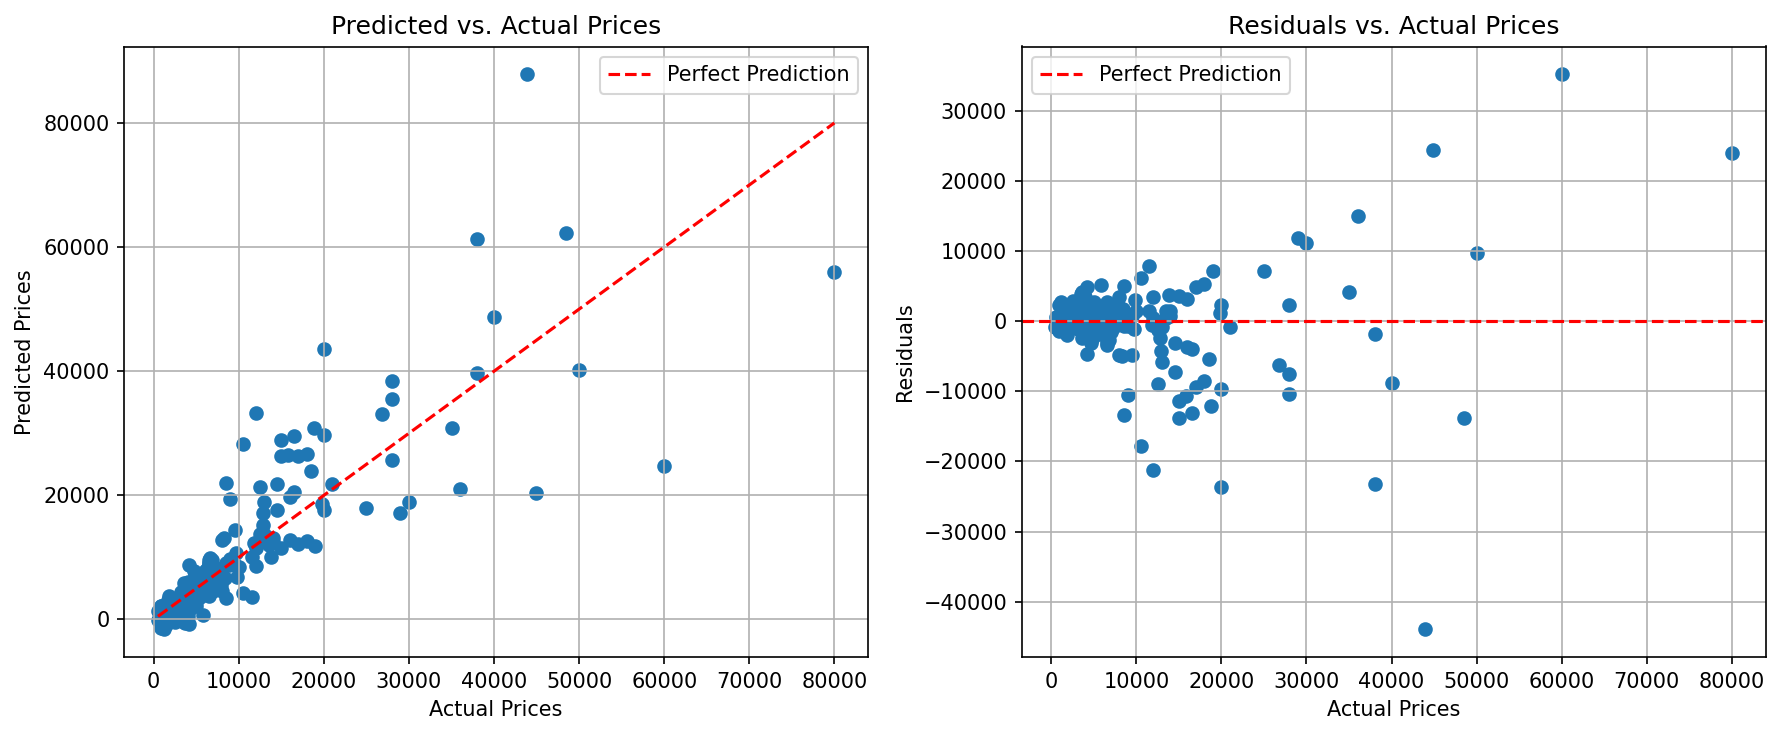

Support Vector Machine


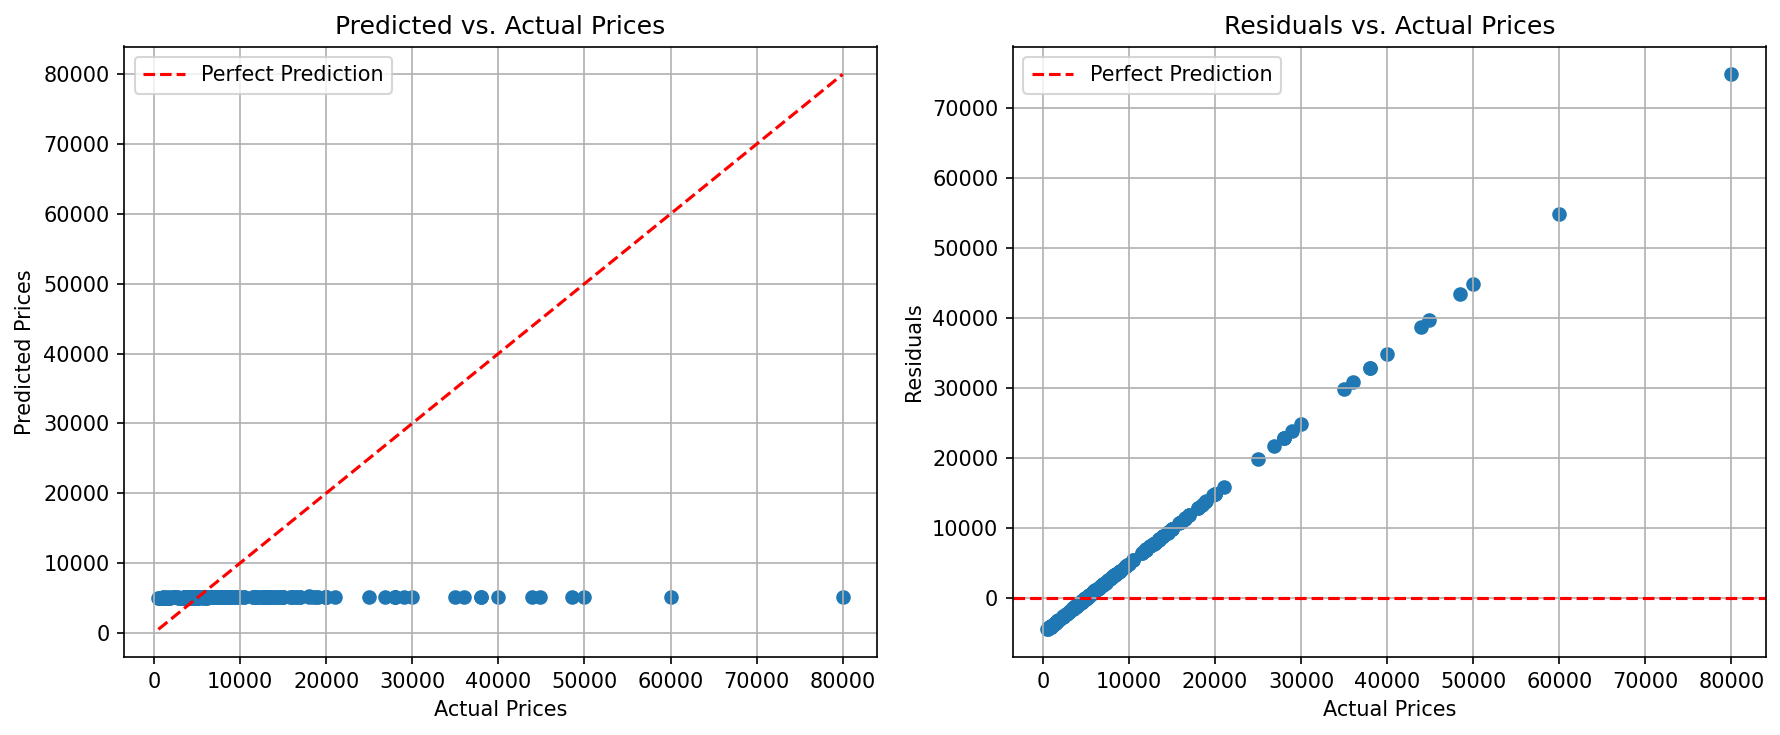

Random Forest


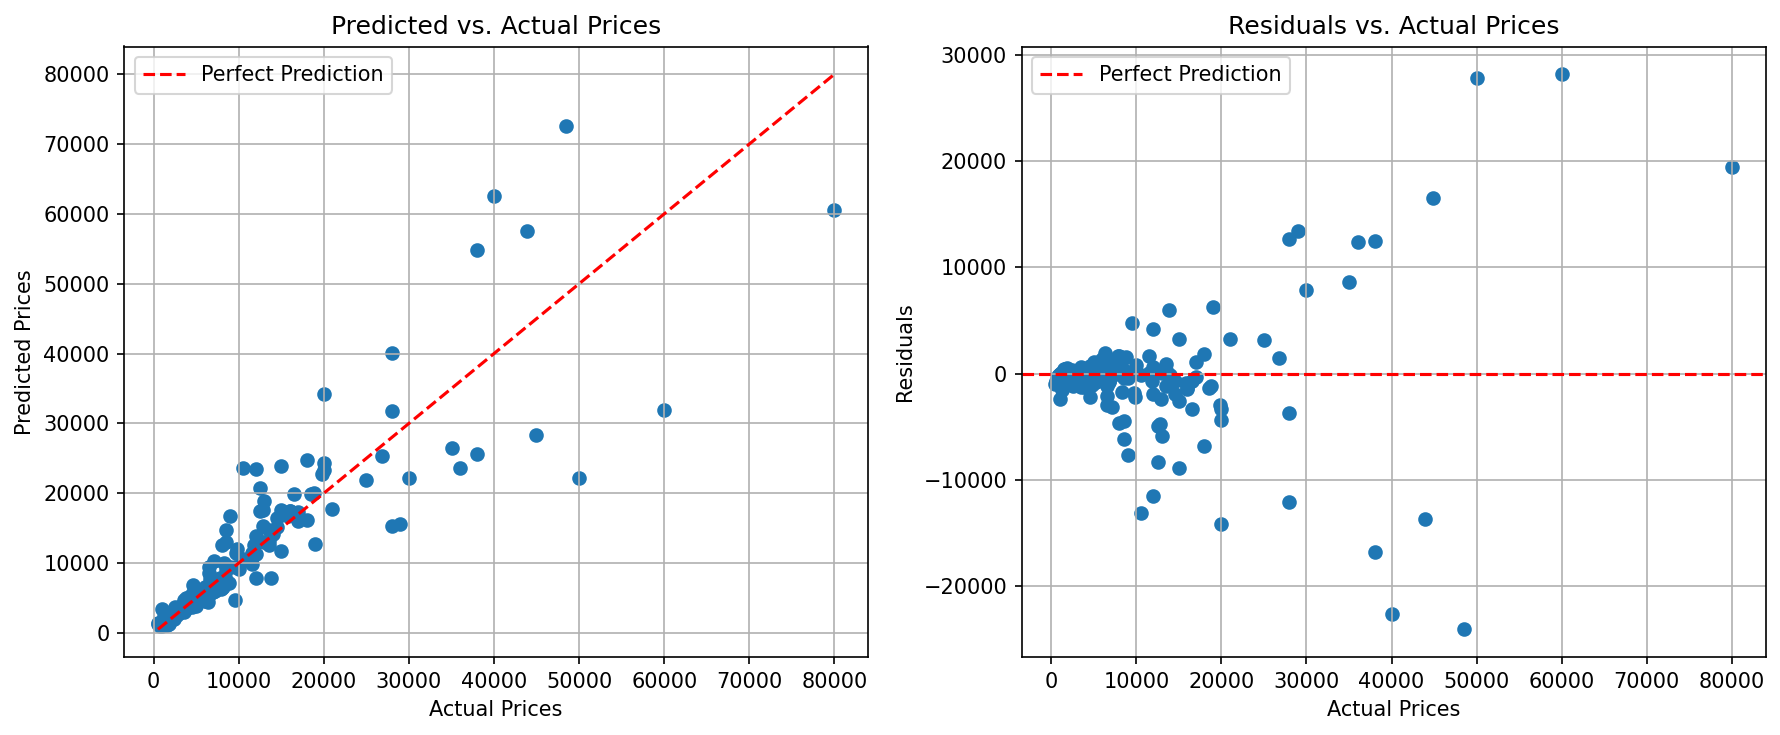

Neural Network


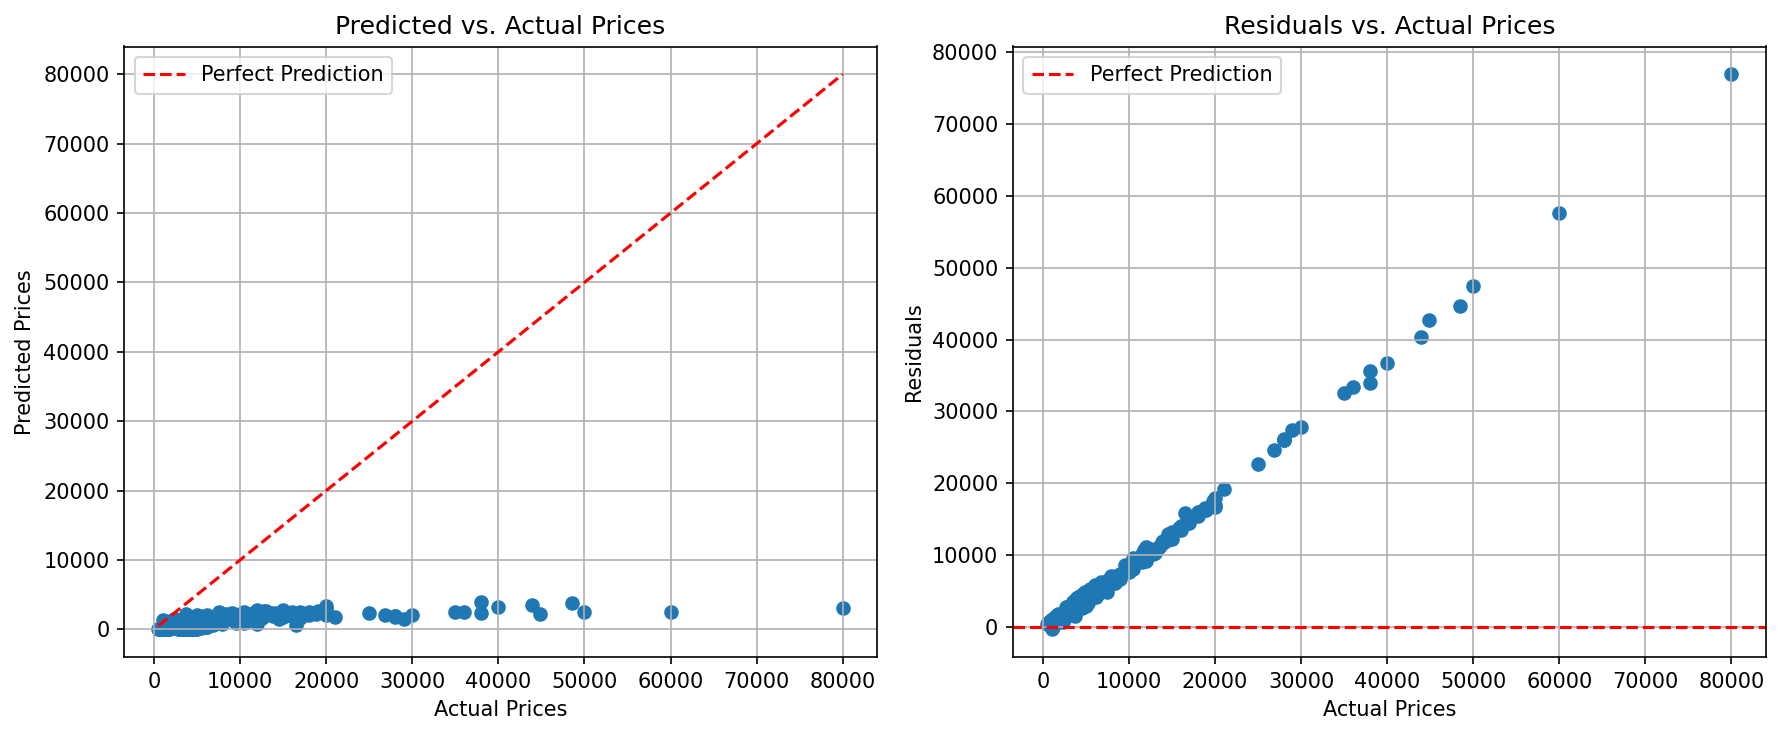

XGBoost


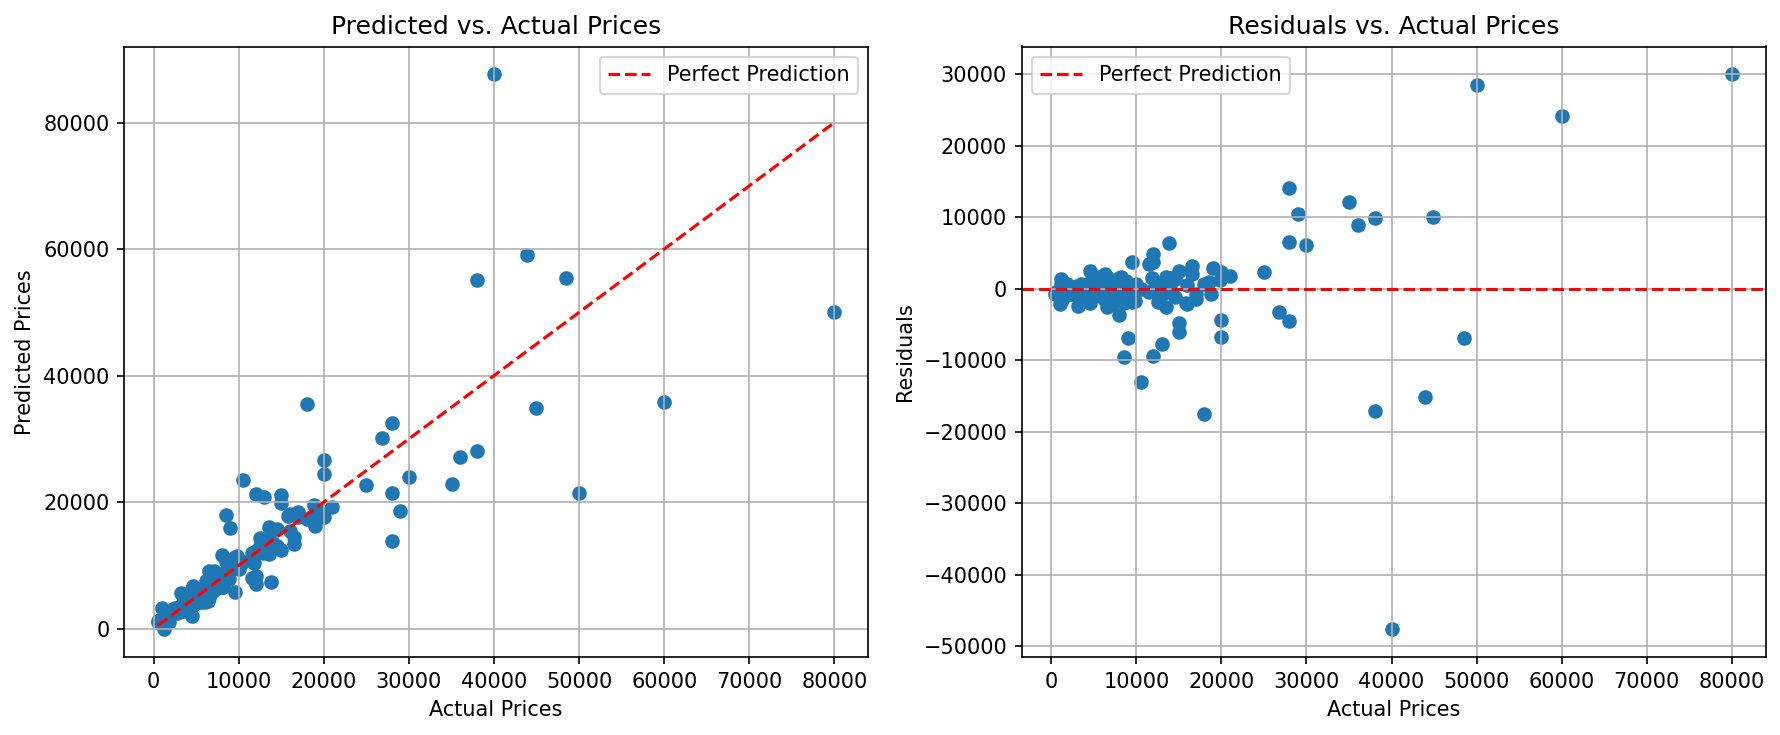

In [39]:
# Plots to evaluate model performance
# Create a dictionary of models with their predicted y values on the validation set
model_dict = {
    "Linear Regression": y_val_pred_reg, 
    "Support Vector Machine": y_val_pred_svm, 
    "Random Forest": y_val_pred_rf, 
    "Neural Network": y_val_pred_mlp,
    "XGBoost": y_val_pred_xgb
}

# Iterate the models
for model, y_val_pred in model_dict.items():
    # Print model name
    print(model)
    
    # Calculate residuals
    residuals = [actual_value - predicted_value for actual_value, predicted_value in zip(y_val, y_val_pred)]

    # Create a 1x2 grid of subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=150)

    # Plot 1: Predicted vs. Actual Prices
    axes[0].scatter(y_val, y_val_pred)
    axes[0].plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color="red", linestyle="--", 
                 label="Perfect Prediction")  # Add diagonal reference line
    axes[0].set_xlabel("Actual Prices")
    axes[0].set_ylabel("Predicted Prices")
    axes[0].set_title("Predicted vs. Actual Prices")
    axes[0].grid(True)
    axes[0].legend() 

    # Plot 2: Residuals vs. Actual Prices
    axes[1].scatter(y_val, residuals)
    axes[1].axhline(y=0, color="red", linestyle="--", label="Perfect Prediction")  # Add horizontal reference line
    axes[1].set_xlabel("Actual Prices")
    axes[1].set_ylabel("Residuals")
    axes[1].set_title("Residuals vs. Actual Prices")
    axes[1].grid(True)
    axes[1].legend() 

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()